**How to identify position players on a given date?**

**Problem:**
<br>
In daily fantasy baseball, a participant sets up their team against another player of their league. Some position players are stars and should play nearly all the time, but often a position is shared between other players on your roster. How do you choose which platooning player to start (especially if there is a limited sample size for the batter facing that pitcher)?

**Strategy:**
<br>
- Focus on features of the batter (e.g. historical batting average) and pitcher (e.g. historical ERA, WHIP) to predict whether the batter would output a hit (or HR, single, double, etc.) in a given batter-pitcher at-bat matchup.

- If you choose a given date (e.g. May 9), you know the starting pitcher a batter would face. Use data to build a model taht predicts how well a batter would do against the pitcher as a guide for a decision. (Lower priority: If the matchup for a particular batter-pitcher is small, find similar players to serve as a guide. Similar players can be found by using Erdos score.)

- How do I know if my strategy is improved over other models? Look at which player one would choose from a simple player ranking.

- Validation: Historical data

This notebook was created within my "insight" virtual environment.

**Inputs and outputs**

*Version 1:*
- Input: Two players under consideration for one position and a date of interest (2019 season for historical validation).
- Output: Player recommendation for that position with a predicted score.

*Version 2:*
- Input: A participant's player roster (e.g. 20 players)
- Output: A recommended lineup.

Order of features of product to incorporate: (still to be determined)

0.  Try a simple model where each at-bat batter-pitcher matchup is simply its own row and selected features are done. (DONE)
1.	Roster’s “basic” baseball statistics from 2018 season? Or 50 games (including previous season) - (minimum viable product level) (DONE)
2.	Specific matchup against that pitcher - “basic” baseball statistics
3.	Roster’s statcast statistics from last 50 games (including previous season) (DONE)
4.	Limit to more recent performance (last 100 at-bats games - dataframe for model does 200 rows)
5.	Weather, park effects, team defense, night/day, lineup order
6. Use batted ball characteristics as a feature of player and pitcher (launch angle average, launch speed average)
7.	Use of player similarity (lower priority)

Similar idea
https://community.fangraphs.com/the-outcome-machine-predicting-at-bats-before-they-happen/


EDA, do HR over time and by date for each player


**Product pitch**

I'm creating a fantasy baseball application that suggests players on a given day. Fantasy baseball has over 11 million participants with the winners of leagues collecting entry fees and host platforms receiving a commission. The projected market for fantasy baseball in 2020 is over 8 billion dollars. A participant's success depends in part on daily player selection. For player selection, participants must rely on their own research or use a site's recommendation, which uses black-box algorithms behind pay walls. I'm developing an alternative algorithm to assist in player selection to save participants time and expose the important features in player performance prediction.

# Ideas

- Will hit happen based on pitch count
- Use last 100 at-bats from the date of interest.
- Use Bayesian?
- EDA  - plot someone's hits over game-dates as a time series
- Look at the player's last 100 hits 

Other:
- Use all info for at-bat and then do backwards selection.

**Motivation: Learning analytics requries some skills I can develop here**

# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from termcolor import colored

# Web/database stuff
import urllib.request
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

# Multiprocessing/threading
import multiprocess
import threading
from threading import Thread

In [2]:
# Web/database stuff
# import urllib.request
# import xml.etree.ElementTree as ET
# from bs4 import BeautifulSoup
import sqlalchemy
import sqlalchemy_utils
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# Multiprocessing/threading
import multiprocess
import threading   # included in base

In [3]:
# Stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [4]:
# ML
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [5]:
# Check versioning
print('numpy: ', np.__version__)
print('pandas: ', pd.__version__)
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
print('sklearn: ', sklearn.__version__)

print('psycopg2: ', psycopg2.__version__)
print('sqlalchemy: ', sqlalchemy.__version__)
print('sqlalchemy_utils: ', sqlalchemy_utils.__version__)
print('multiprocess: ', multiprocess.__version__)

numpy:  1.17.4
pandas:  0.25.3
matplotlib:  3.1.1
seaborn:  0.9.0
sklearn:  0.22
psycopg2:  2.8.4 (dt dec pq3 ext lo64)
sqlalchemy:  1.3.11
sqlalchemy_utils:  0.36.1
multiprocess:  0.70.9


In [6]:
# Code formatting with Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [7]:
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup

<IPython.core.display.Javascript object>

# Database info

In [8]:
# Define a database name
# Set your postgres username
dbname = "baseball"
username = "lacar"  # change this to your username

<IPython.core.display.Javascript object>

In [9]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine("postgres://%s@localhost/%s" % (username, dbname))
print(engine.url)

postgres://lacar@localhost/baseball


<IPython.core.display.Javascript object>

**Statcast data to database**
<br>
(done already, see previous versions of notebooks)

## Use this notebook to add data while working in other notebook

In [640]:
# 2016 regular season
df_statcast_16 = statcast("2016-04-03", "2016-09-30")



This is a large query, it may take a moment to complete
Completed sub-query from 2016-04-03 to 2016-04-08
Completed sub-query from 2016-04-09 to 2016-04-14
Completed sub-query from 2016-04-15 to 2016-04-20
Completed sub-query from 2016-04-21 to 2016-04-26
Completed sub-query from 2016-04-27 to 2016-05-02
Completed sub-query from 2016-05-03 to 2016-05-08
Completed sub-query from 2016-05-09 to 2016-05-14
Completed sub-query from 2016-05-15 to 2016-05-20
Completed sub-query from 2016-05-21 to 2016-05-26
Completed sub-query from 2016-05-27 to 2016-06-01
Completed sub-query from 2016-06-02 to 2016-06-07
Completed sub-query from 2016-06-08 to 2016-06-13
Completed sub-query from 2016-06-14 to 2016-06-19
Completed sub-query from 2016-06-20 to 2016-06-25
Completed sub-query from 2016-06-26 to 2016-07-01
Completed sub-query from 2016-07-02 to 2016-07-07
Completed sub-query from 2016-07-08 to 2016-07-13
Completed sub-query from 2016-07-14 to 2016-07-19
Completed sub-query from 2016-07-20 to 2016-

<IPython.core.display.Javascript object>

In [641]:
# Send to database
# df_statcast_16.to_sql("statcast_16", engine)

<IPython.core.display.Javascript object>

In [10]:
## create a database (if it doesn't exist)
# if not database_exists(engine.url):
#     create_database(engine.url)
# print(database_exists(engine.url))

<IPython.core.display.Javascript object>

In [11]:
# This is done, but note it's out of order

# date_list = [
#     ("2019-03-20", "2019-09-29"),
#     ("2018-03-29", "2018-10-01"),
#     ("2017-04-02", "2017-10-01"),
# ]

# Above gave **2,174,906** pitch-by-pitch results in the database

#     ("2016-04-03", "2016-10-02"),   # didn't get
#     ("2015-04-05", "2015-10-04"),   # didn't get


# for i, date_pair in enumerate(date_list):
#     if i < 1:
#         df_sc = statcast(date_pair[0], date_pair[1])
#         df_sc.to_sql("statcast", engine, if_exists="replace")
#         print(date_pair, "replace mode")
#     else:
#         df_sc = statcast(date_pair[0], date_pair[1])
#         df_sc.to_sql("statcast", engine, if_exists="append")
#         print(date_pair, "append mode")

<IPython.core.display.Javascript object>

In [12]:
# Working with PostgreSQL in Python
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database=dbname, user=username)

<IPython.core.display.Javascript object>

See other notebook for more info



In [13]:
# Get player id
sql_query = """
SELECT * FROM player_id;
"""

df_player_id = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [14]:
# Batting stats

sql_query = """
SELECT * FROM batting_stats18_wpid;
"""

df_batting_stats_wpid = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [15]:
df_batting_stats_wpid.shape

(955, 300)

<IPython.core.display.Javascript object>

In [16]:
df_batting_stats_wpid.head()

,index,index_x,Season,Name,Team,Age,G,AB,PA,H,...,first_name,index_y,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,63,2018.0,Mookie Betts,Red Sox,25.0,136.0,520.0,614.0,180.0,...,mookie,166,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
1,1,67,2018.0,Mike Trout,Angels,26.0,140.0,471.0,608.0,147.0,...,mike,1789,trout,mike,545361,troum001,troutmi01,10155,2011.0,2019.0
2,2,153,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,...,jose,1417,ramirez,jose,542432,ramij004,ramirjo02,10171,2014.0,2018.0
3,68,38,2018.0,Ryder Jones,Giants,24.0,5.0,8.0,8.0,3.0,...,ryder,903,jones,ryder,624507,joner005,jonesry01,15982,2017.0,2018.0
4,3,153,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,...,jose,1418,ramirez,jose,608070,ramij003,ramirjo01,13510,2013.0,2019.0


<IPython.core.display.Javascript object>

In [17]:
# Pitching stats

sql_query = """
SELECT * FROM pitching_stats_wpid;
"""

df_pitching_stats_wpid = pd.read_sql_query(sql_query, con)
# Limit to 2018, like with baseball stats
df_pitching_stats_wpid = df_pitching_stats_wpid[
    df_pitching_stats_wpid["Season"] == 2018
].copy()

<IPython.core.display.Javascript object>

In [18]:
df_pitching_stats_wpid.shape

(789, 310)

<IPython.core.display.Javascript object>

In [19]:
df_pitching_stats_wpid.head()

,index,Season,Name,Team,Age,W,L,ERA,WAR,G,...,first_name,last_name,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,2018.0,Jacob deGrom,Mets,30.0,10.0,9.0,1.70,9.0,32.0,...,jacob,degrom,degrom,jacob,594798.0,degrj001,degroja01,10954.0,2014.0,2019.0
2,2,2018.0,Max Scherzer,Nationals,33.0,18.0,7.0,2.53,7.5,33.0,...,max,scherzer,scherzer,max,453286.0,schem001,scherma01,3137.0,2008.0,2019.0
4,1587,2018.0,Scott Kingery,Phillies,24.0,0.0,0.0,13.50,0.0,1.0,...,scott,kingery,kingery,scott,664068.0,kings001,kingesc01,17975.0,2018.0,2019.0
8,7,2018.0,Justin Verlander,Astros,35.0,16.0,9.0,2.52,6.6,34.0,...,justin,verlander,verlander,justin,434378.0,verlj001,verlaju01,8700.0,2005.0,2019.0
12,11,2018.0,Chris Sale,Red Sox,29.0,12.0,4.0,2.11,6.2,27.0,...,chris,sale,sale,chris,519242.0,salec001,salech01,10603.0,2010.0,2019.0


<IPython.core.display.Javascript object>

# Notes

## Contingencies

1. What if player has day off? or no game is scheduled?
2. What if player or pitcher doesn't have minimum nback at-bats?
3. What if player doesn't have minimum nback at-bats against same or opposite handedness?

**Quora answer on number of plate appearances**
https://www.quora.com/How-many-at-bats-does-the-average-MLB-player-go-through-per-year

One direction to go with is how many PA wpild a player accumulate if theu were to play every day, and not rest. That would be around 725. Though that total is not really an average as few players exceed such a total each year.

A second number would be how many plate appearances bases on normal rest during a season if a player never was injured, about 145-150 games for position players other then the catcher and 110 to 115 for catchers. Those totals would be around 650 and 450 respectively.

Yet another way to answer this would be the number of PA by all position players on a roster that were supposed to be starters, but may receive less playing time due to injury or a team developing, trading for or discovering a better player. That would probably be closer to 400.

You could also thing about all position players on a team including bench players, if we include them our total now is closer to 200-250.

Yet another way to look at this is to include all players on the roster including pitcher who may notbat intentionally. Include them and tour total is closer to 100-120.

## Other ideas


- Look at probabilities, instead of looking for 1 (done - not strong)
- Aggregate per game (potentially something there - not sure)
- Look at Ty France
- Add in pitcher info 
- See what pitches they're hitting, then see how that matches with pitchers 
- Remember that ultimately, we want to see that we're picking the right player - someone who has a higher probability overall will be better choice


**Motivation: Learning analytics requries some skills I can develop here**

## Questions to ask

- Am I inputting handedness correctly? How to input values if they're transformed in the model? (L -1.41421356, R 0.70710678)
- Add pitcher specific ID as a factor?


## Things to fix

- Why is dataframe model going to <200 - cause of the day of separation.
- Standardize train-test before split

# Build one model

In [464]:
def get_sc_event_data():
    sql_query = """
    (SELECT statcast.game_date, statcast.batter,
    statcast.pitcher, statcast.events,
    statcast.stand, statcast.p_throws,
    statcast.inning_topbot
    FROM statcast
    WHERE statcast.events IS NOT NULL);
    """

    print(sql_query)

    df_sc_events = pd.read_sql_query(sql_query, con)

    return df_sc_events

<IPython.core.display.Javascript object>

In [465]:
sql_query = """
SELECT * FROM batting_stats18_wpid;
"""

print(sql_query)

df_batting = pd.read_sql_query(sql_query, con)
df_batting.drop(["index", "index_x"], axis=1)


SELECT * FROM batting_stats18_wpid;



,Season,Name,Team,Age,G,AB,PA,H,1B,2B,...,first_name,index_y,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,2018.0,Mookie Betts,Red Sox,25.0,136.0,520.0,614.0,180.0,96.0,47.0,...,mookie,166,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
1,2018.0,Mike Trout,Angels,26.0,140.0,471.0,608.0,147.0,80.0,24.0,...,mike,1789,trout,mike,545361,troum001,troutmi01,10155,2011.0,2019.0
2,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,75.0,38.0,...,jose,1417,ramirez,jose,542432,ramij004,ramirjo02,10171,2014.0,2018.0
3,2018.0,Ryder Jones,Giants,24.0,5.0,8.0,8.0,3.0,1.0,0.0,...,ryder,903,jones,ryder,624507,joner005,jonesry01,15982,2017.0,2018.0
4,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,75.0,38.0,...,jose,1418,ramirez,jose,608070,ramij003,ramirjo01,13510,2013.0,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,2018.0,Pat Valaika,Rockies,25.0,68.0,122.0,133.0,19.0,12.0,5.0,...,pat,1813,valaika,pat,642162,valap001,valaipa01,14885,2016.0,2019.0
951,2018.0,Yangervis Solarte,Blue Jays,30.0,122.0,468.0,506.0,106.0,69.0,20.0,...,yangervis,1660,solarte,yangervis,500208,solay001,solarya01,5352,2014.0,2019.0
952,2018.0,Magneuris Sierra,Marlins,22.0,54.0,147.0,156.0,28.0,25.0,3.0,...,magneuris,1615,sierra,magneuris,642423,sierm002,sierrma01,17023,2017.0,2019.0
953,2018.0,Victor Martinez,Tigers,39.0,133.0,467.0,508.0,117.0,87.0,21.0,...,victor,1100,martinez,victor,400121,martv001,martivi01,393,2002.0,2018.0


<IPython.core.display.Javascript object>

In [466]:
df_batting.shape

(955, 300)

<IPython.core.display.Javascript object>

In [467]:
sql_query = """
SELECT * FROM pitching_stats_wpid;
"""

print(sql_query)

df_pitching = pd.read_sql_query(sql_query, con)
df_pitching = df_pitching[df_pitching["Season"] == 2018].copy()

df_pitching.drop(["index"], axis=1)


SELECT * FROM pitching_stats_wpid;



,Season,Name,Team,Age,W,L,ERA,WAR,G,GS,...,first_name,last_name,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,2018.0,Jacob deGrom,Mets,30.0,10.0,9.0,1.70,9.0,32.0,32.0,...,jacob,degrom,degrom,jacob,594798.0,degrj001,degroja01,10954.0,2014.0,2019.0
2,2018.0,Max Scherzer,Nationals,33.0,18.0,7.0,2.53,7.5,33.0,33.0,...,max,scherzer,scherzer,max,453286.0,schem001,scherma01,3137.0,2008.0,2019.0
4,2018.0,Scott Kingery,Phillies,24.0,0.0,0.0,13.50,0.0,1.0,0.0,...,scott,kingery,kingery,scott,664068.0,kings001,kingesc01,17975.0,2018.0,2019.0
8,2018.0,Justin Verlander,Astros,35.0,16.0,9.0,2.52,6.6,34.0,34.0,...,justin,verlander,verlander,justin,434378.0,verlj001,verlaju01,8700.0,2005.0,2019.0
12,2018.0,Chris Sale,Red Sox,29.0,12.0,4.0,2.11,6.2,27.0,27.0,...,chris,sale,sale,chris,519242.0,salec001,salech01,10603.0,2010.0,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,2018.0,Blaine Boyer,Royals,36.0,2.0,1.0,12.05,-0.8,21.0,0.0,...,blaine,boyer,boyer,blaine,430641.0,boyeb001,boyerbl01,2237.0,2005.0,2018.0
2336,2018.0,Brandon Maurer,Royals,27.0,0.0,4.0,7.76,-0.8,37.0,0.0,...,brandon,maurer,maurer,brandon,543506.0,maurb001,maurebr01,4878.0,2013.0,2018.0
2341,2018.0,Matt Albers,Brewers,35.0,3.0,3.0,7.34,-0.9,34.0,0.0,...,matt,albers,albers,matt,458006.0,albem001,alberma01,4300.0,2006.0,2019.0
2359,2018.0,Jarlin Garcia,Marlins,25.0,3.0,3.0,4.91,-1.3,29.0,7.0,...,jarlin,garcia,garcia,jarlin,606424.0,garcj006,garcija04,18282.0,2017.0,2019.0


<IPython.core.display.Javascript object>

In [468]:
df_pitching.shape

(789, 310)

<IPython.core.display.Javascript object>

In [469]:
df_sc_events = get_sc_event_data()


    (SELECT statcast.game_date, statcast.batter,
    statcast.pitcher, statcast.events,
    statcast.stand, statcast.p_throws,
    statcast.inning_topbot
    FROM statcast
    WHERE statcast.events IS NOT NULL);
    


<IPython.core.display.Javascript object>

In [471]:
print("size of data frame: ", df_sc_events.shape)

size of data frame:  (555396, 7)


<IPython.core.display.Javascript object>

In [472]:
df_sc_events.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot
0,2017-04-03,425783.0,446372.0,strikeout,L,R,Bot
1,2017-04-03,488726.0,506433.0,field_out,L,R,Top
2,2017-04-03,596019.0,506433.0,grounded_into_double_play,L,R,Top
3,2017-04-03,467793.0,506433.0,walk,L,R,Top
4,2017-04-03,501659.0,506433.0,walk,L,R,Top


<IPython.core.display.Javascript object>

In [473]:
df_sc_events4model = df_sc_events.copy()

<IPython.core.display.Javascript object>

In [474]:
df_sc_events4model.shape

(555396, 7)

<IPython.core.display.Javascript object>

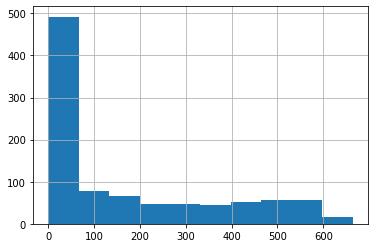

<IPython.core.display.Javascript object>

In [475]:
df_batting_stats_wpid["AB"].hist()

In [476]:
df_batting_stats_wpid_100ab = df_batting_stats_wpid[
    df_batting_stats_wpid["AB"] > 100
].copy()

<IPython.core.display.Javascript object>

In [477]:
df_batting_stats_wpid_100ab.shape

(420, 300)

<IPython.core.display.Javascript object>

In [478]:
len(df_batting_stats_wpid["key_mlbam"].unique())

955

<IPython.core.display.Javascript object>

## Batter features

In [642]:
# Merge batter characteristics
colbatter2get = ["WAR", "OBP", "SLG", "OPS", "BB_perc", "K_perc", "key_mlbam"]

df_sc_events4model_b = pd.merge(
    df_sc_events4model,
    df_batting_stats_wpid_100ab[colbatter2get],
    left_on="batter",
    right_on="key_mlbam",
)

<IPython.core.display.Javascript object>

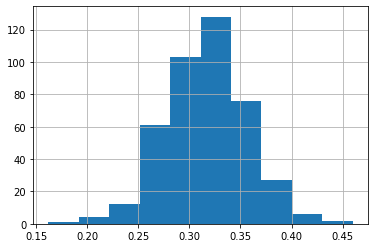

<IPython.core.display.Javascript object>

In [643]:
df_batting_stats_wpid_100ab["OBP"].hist()

In [644]:
df_sc_events4model_b.shape

(447172, 14)

<IPython.core.display.Javascript object>

### Try some feature engineering off raw statcast data

## Pitcher features

In [645]:
len(df_pitching_stats_wpid["key_mlbam"].unique())

763

<IPython.core.display.Javascript object>

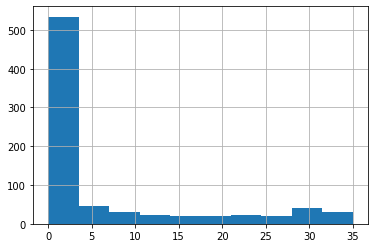

<IPython.core.display.Javascript object>

In [646]:
df_pitching_stats_wpid["GS"].hist()

In [647]:
df_pitching_stats_wpid_sp = df_pitching_stats_wpid[
    df_pitching_stats_wpid["GS"] > 5
].copy()

<IPython.core.display.Javascript object>

In [648]:
df_pitching_stats_wpid_sp.shape

(218, 310)

<IPython.core.display.Javascript object>

Text(0, 0.5, 'No. of pitchers')

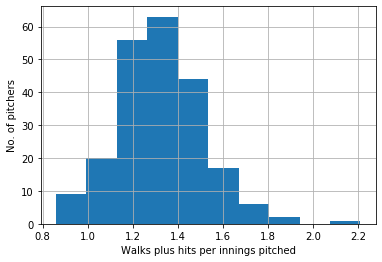

<IPython.core.display.Javascript object>

In [649]:
f, ax1 = plt.subplots()
df_pitching_stats_wpid_sp["WHIP"].hist(ax=ax1)
ax1.set_xlabel("Walks plus hits per innings pitched")
ax1.set_ylabel("No. of pitchers")

In [650]:
# Merge pitcher characteristics
colpitcher2get = ["WAR", "WHIP", "ERA", "BB/9", "K/9", "key_mlbam"]

df_sc_events4model_bp = pd.merge(
    df_sc_events4model_b,
    df_pitching_stats_wpid_sp[colpitcher2get],
    left_on="pitcher",
    right_on="key_mlbam",
)

<IPython.core.display.Javascript object>

In [651]:
df_sc_events4model_bp.shape

(232703, 20)

<IPython.core.display.Javascript object>

In [652]:
df_sc_events4model_bp.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,OPS,BB_perc,K_perc,key_mlbam_x,WAR_y,WHIP,ERA,BB/9,K/9,key_mlbam_y
0,2017-04-03,425783.0,446372.0,strikeout,L,R,Bot,2.3,0.377,0.434,0.81,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0
1,2017-04-03,425783.0,446372.0,field_out,L,R,Bot,2.3,0.377,0.434,0.81,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0
2,2017-04-03,425783.0,446372.0,field_out,L,R,Bot,2.3,0.377,0.434,0.81,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0
3,2018-05-02,425783.0,446372.0,field_out,L,R,Top,2.3,0.377,0.434,0.81,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0
4,2018-05-02,425783.0,446372.0,single,L,R,Top,2.3,0.377,0.434,0.81,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0


<IPython.core.display.Javascript object>

In [653]:
# Encode events
event_list = ["hit_by_pitch", "walk", "single", "double", "triple", "home_run"]
df_sc_events4model_bp["event_code"] = 0
df_sc_events4model_bp.loc[
    df_sc_events4model_bp["events"].isin(event_list), "event_code"
] = 1

<IPython.core.display.Javascript object>

### Simple check - only OBP, WHIP and event detection
- strip batter, pitcher identity

In [658]:
col2keep = ["event_code", "OBP", "WHIP"]

df_sc_events4model_bp_simplecheck = df_sc_events4model_bp[col2keep].copy()

<IPython.core.display.Javascript object>

In [659]:
df_sc_events4model_bp_simplecheck.head()

,event_code,OBP,WHIP
0,0,0.377,0.99
1,0,0.377,0.99
2,0,0.377,0.99
3,0,0.377,0.99
4,1,0.377,0.99


<IPython.core.display.Javascript object>

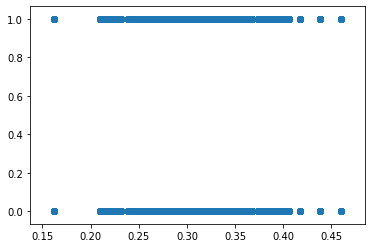

<IPython.core.display.Javascript object>

In [656]:
f, ax1 = plt.subplots()
ax1.scatter(
    df_sc_events4model_bp_simplecheck["OBP"],
    df_sc_events4model_bp_simplecheck["event_code"],
)

In [661]:
X_train_scale_1M, X_test_scale_1M, y_train_1M, y_test_1M, scale_vals = get_split_data(
    df_sc_events4model_bp_simplecheck, 0.4
)

<IPython.core.display.Javascript object>

In [733]:
def run_logreg_model(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    log_reg = LogisticRegression(class_weight="balanced")
    log_reg.fit(X_train_scale_set, y_train_set)

    y_pred = log_reg.predict(X_test_scale_set)
    y_predprob = log_reg.predict_proba(X_test_scale_set)[:, 1]
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred, "predprob": y_predprob})

    return log_reg, df_eval

<IPython.core.display.Javascript object>

In [734]:
# Run models
log_reg_1M, df_eval_1M = run_logreg_model(
    X_train_scale_1M, y_train_1M, X_test_scale_1M, y_test_1M
)

<IPython.core.display.Javascript object>

In [735]:
df_eval_1M.head()

,test,pred,predprob
116951,1,1,0.528203
146125,1,0,0.479493
142042,0,1,0.523284
57356,0,1,0.574968
67644,0,1,0.573082


<IPython.core.display.Javascript object>

In [736]:
print(metrics.classification_report(df_eval_1M["test"], df_eval_1M["pred"]))

              precision    recall  f1-score   support

           0       0.70      0.55      0.61     62864
           1       0.35      0.52      0.42     30218

    accuracy                           0.54     93082
   macro avg       0.53      0.53      0.52     93082
weighted avg       0.59      0.54      0.55     93082



<IPython.core.display.Javascript object>

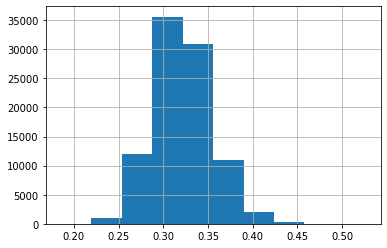

<IPython.core.display.Javascript object>

In [680]:
df_eval_1M["predprob"].hist()

In [681]:
df_temp = pd.merge(
    df_eval_1M, df_sc_events4model_bp_simplecheck, left_index=True, right_index=True
)

<IPython.core.display.Javascript object>

In [682]:
df_temp.head()

,test,pred,predprob,event_code,OBP,WHIP
116951,1,0,0.343435,1,0.290,1.77
146125,1,0,0.305458,1,0.303,1.30
142042,0,0,0.339035,0,0.352,1.29
57356,0,0,0.392314,0,0.460,1.03
67644,0,0,0.389803,0,0.366,1.67


<IPython.core.display.Javascript object>

Text(0.5, 0, 'WHIP')

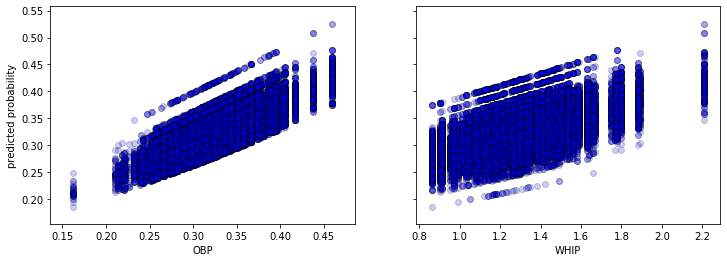

<IPython.core.display.Javascript object>

In [702]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax1.scatter(
    df_temp["OBP"], df_temp["predprob"], facecolor="blue", edgecolors="black", alpha=0.2
)
ax1.set_xlabel("OBP")
ax1.set_ylabel("predicted probability")

ax2.scatter(
    df_temp["WHIP"],
    df_temp["predprob"],
    facecolor="blue",
    edgecolors="black",
    alpha=0.2,
)
ax2.set_xlabel("WHIP");

Text(0.5, 0, 'OBP')

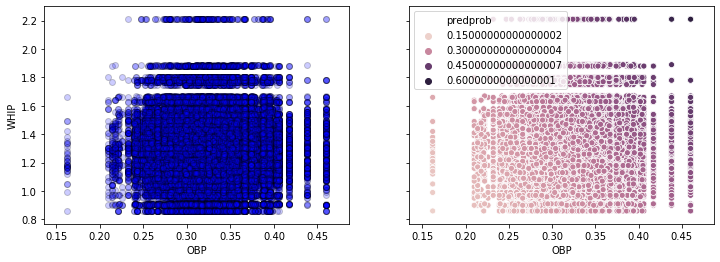

<IPython.core.display.Javascript object>

In [701]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax1.scatter(
    df_temp["OBP"], df_temp["WHIP"], facecolor="blue", edgecolors="black", alpha=0.2
)
ax1.set_ylabel("WHIP")
ax1.set_xlabel("OBP")

sns.scatterplot(
    data=df_temp, x="OBP", y="WHIP", hue="predprob", ax=ax2
)  # , legend=False)

ax2.set_xlabel("OBP")

In [700]:
print("logistic regression coefficients: ", log_reg_1M.coef_)

logistic regression coefficients:  [[0.1218267  0.08641798]]


<IPython.core.display.Javascript object>

### More simple features

In [737]:
df_sc_events4model_bp.columns

Index(['game_date', 'batter', 'pitcher', 'events', 'stand', 'p_throws',
       'inning_topbot', 'WAR_x', 'OBP', 'SLG', 'OPS', 'BB_perc', 'K_perc',
       'key_mlbam_x', 'WAR_y', 'WHIP', 'ERA', 'BB/9', 'K/9', 'key_mlbam_y',
       'event_code'],
      dtype='object')

<IPython.core.display.Javascript object>

In [738]:
col2keep = ["event_code", "OBP", "WHIP", "stand", "p_throws"]

df_sc_events4model_bp_simplecheck = df_sc_events4model_bp[col2keep].copy()

df_sc_events4model_bp_simplecheck["stand"].replace({"L": 0, "R": 1}, inplace=True)
df_sc_events4model_bp_simplecheck["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

<IPython.core.display.Javascript object>

In [739]:
df_sc_events4model_bp_simplecheck.head()

,event_code,OBP,WHIP,stand,p_throws
0,0,0.377,0.99,0,1
1,0,0.377,0.99,0,1
2,0,0.377,0.99,0,1
3,0,0.377,0.99,0,1
4,1,0.377,0.99,0,1


<IPython.core.display.Javascript object>

In [740]:
X_train_scale_1M, X_test_scale_1M, y_train_1M, y_test_1M, scale_vals = get_split_data(
    df_sc_events4model_bp_simplecheck, 0.4
)

<IPython.core.display.Javascript object>

In [741]:
df_eval_1M.head()

,test,pred,predprob
116951,1,1,0.528203
146125,1,0,0.479493
142042,0,1,0.523284
57356,0,1,0.574968
67644,0,1,0.573082


<IPython.core.display.Javascript object>

In [742]:
print(metrics.classification_report(df_eval_1M["test"], df_eval_1M["pred"]))

              precision    recall  f1-score   support

           0       0.70      0.55      0.61     62864
           1       0.35      0.52      0.42     30218

    accuracy                           0.54     93082
   macro avg       0.53      0.53      0.52     93082
weighted avg       0.59      0.54      0.55     93082



<IPython.core.display.Javascript object>

In [709]:
df_temp = pd.merge(
    df_eval_1M, df_sc_events4model_bp_simplecheck, left_index=True, right_index=True
)

<IPython.core.display.Javascript object>

In [710]:
df_temp.head()

,test,pred,predprob,event_code,OBP,WHIP,stand,p_throws
116951,1,0,0.343435,1,0.290,1.77,1,0
146125,1,0,0.305458,1,0.303,1.30,1,1
142042,0,0,0.339035,0,0.352,1.29,0,0
57356,0,0,0.392314,0,0.460,1.03,1,1
67644,0,0,0.389803,0,0.366,1.67,0,1


<IPython.core.display.Javascript object>

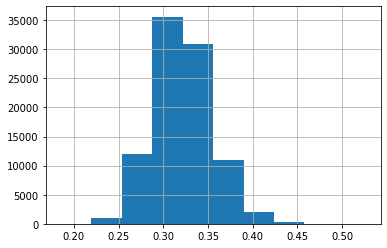

<IPython.core.display.Javascript object>

In [711]:
# Right-handed batters against right-handed pitchersdf_temp["predprob"].hist()

Text(0.5, 1.0, 'R vs. L')

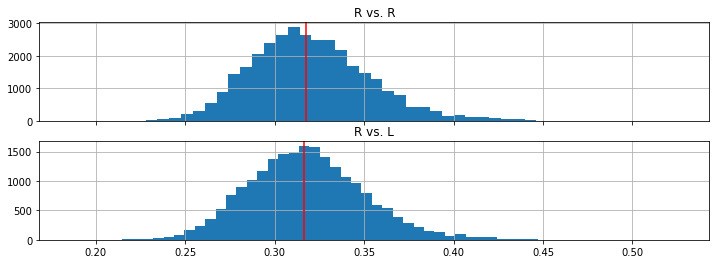

<IPython.core.display.Javascript object>

In [726]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

# Right-handed batters against right-handed pitchers
df_temp_RR = df_temp[(df_temp["stand"] == 1) & (df_temp["p_throws"] == 1)].copy()
df_temp_RR["predprob"].hist(bins=50, ax=ax1)
ax1.axvline(x=df_temp_RR["predprob"].median(), ymin=0, ymax=3000, color="red")
ax1.set_title("R vs. R")

# Right-handed batters against left-handed pitchers
df_temp_RL = df_temp[(df_temp["stand"] == 1) & (df_temp["p_throws"] == 0)].copy()
df_temp_RL["predprob"].hist(bins=50, ax=ax2)
ax2.axvline(x=df_temp_RL["predprob"].median(), ymin=0, ymax=3000, color="red")
ax2.set_title("R vs. L")

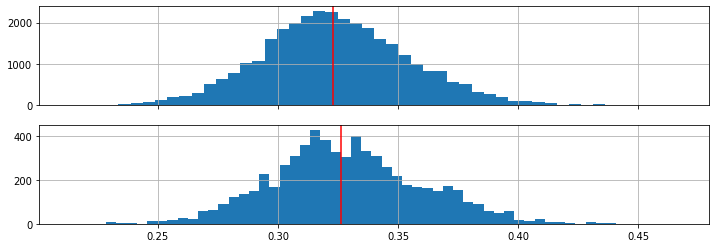

<IPython.core.display.Javascript object>

In [723]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

# Left-handed batters against right-handed pitchers
df_temp_LR = df_temp[(df_temp['stand']==0) & (df_temp['p_throws']==1)].copy()
df_temp_LR['predprob'].hist(bins=50, ax=ax1)
ax1.axvline(x=df_temp_LR["predprob"].median(), ymin=0, ymax=3000, color='red')
ax1.set_title('L vs. R')

# Left-handed batters against left-handed pitchers
df_temp_LL = df_temp[(df_temp['stand']==0) & (df_temp['p_throws']==0)].copy()
df_temp_LL['predprob'].hist(bins=50, ax=ax2)
ax2.axvline(x=df_temp_LL["predprob"].median(), ymin=0, ymax=3000, color='red')
ax2.set_title('L vs. L')


In [714]:
df_temp_RL.head()

,test,pred,predprob,event_code,OBP,WHIP,stand,p_throws
116951,1,0,0.343435,1,0.290,1.77,1,0
54294,0,0,0.329671,0,0.356,1.17,1,0
179052,1,0,0.297914,1,0.282,1.37,1,0
201265,0,0,0.267126,0,0.252,1.25,1,0
176854,0,0,0.323166,0,0.327,1.31,1,0


<IPython.core.display.Javascript object>

In [731]:
df_temp.groupby(["stand", "p_throws"]).mean()[["event_code", "predprob"]]

event_code  predprob
stand p_throws                      
0     0           0.309752  0.328529
      1           0.332953  0.324170
1     0           0.331221  0.318084
      1           0.315277  0.320297

<IPython.core.display.Javascript object>

In [729]:
df_temp.groupby(["stand", "p_throws"]).count()["event_code"]

stand  p_throws
0      0            6460
       1           32389
1      0           20986
       1           33247
Name: event_code, dtype: int64

<IPython.core.display.Javascript object>

### Adding other features

In [491]:
# OHE batter, pitcher handedness
# OHE top/away, home/bottom
df_sc_events4model_bp_ohe = pd.get_dummies(
    df_sc_events4model_bp, prefix=["bs"], columns=["stand"]
)

df_sc_events4model_bp_ohe = pd.get_dummies(
    df_sc_events4model_bp_ohe, prefix=["pt"], columns=["p_throws"]
)

df_sc_events4model_bp_ohe = pd.get_dummies(
    df_sc_events4model_bp_ohe, prefix=["ah"], columns=["inning_topbot"]
)


<IPython.core.display.Javascript object>

In [492]:
df_sc_events4model_bp_ohe.head()

,game_date,batter,pitcher,events,WAR_x,OBP,SLG,OPS,BB_perc,K_perc,...,BB/9,K/9,key_mlbam_y,event_code,bs_L,bs_R,pt_L,pt_R,ah_Bot,ah_Top
0,2017-04-03,425783.0,446372.0,strikeout,2.3,0.377,0.434,0.81,0.138,0.235,...,1.42,9.29,446372.0,0,1,0,0,1,1,0
1,2017-04-03,425783.0,446372.0,field_out,2.3,0.377,0.434,0.81,0.138,0.235,...,1.42,9.29,446372.0,0,1,0,0,1,1,0
2,2017-04-03,425783.0,446372.0,field_out,2.3,0.377,0.434,0.81,0.138,0.235,...,1.42,9.29,446372.0,0,1,0,0,1,1,0
3,2018-05-02,425783.0,446372.0,field_out,2.3,0.377,0.434,0.81,0.138,0.235,...,1.42,9.29,446372.0,0,1,0,0,1,0,1
4,2018-05-02,425783.0,446372.0,single,2.3,0.377,0.434,0.81,0.138,0.235,...,1.42,9.29,446372.0,1,1,0,0,1,0,1


<IPython.core.display.Javascript object>

In [493]:
# OHE pitcher
df_sc_events4model_bp_ohe = pd.get_dummies(
    df_sc_events4model_bp_ohe, prefix=["p"], columns=["pitcher"]
)

# OHE batter
df_sc_events4model_bp_ohe = pd.get_dummies(
    df_sc_events4model_bp_ohe, prefix=["b"], columns=["batter"]
)

<IPython.core.display.Javascript object>

In [494]:
col2remove = ["game_date", "events", "key_mlbam_x", "key_mlbam_y"]
all_col = df_sc_events4model_bp_ohe.columns.tolist()

<IPython.core.display.Javascript object>

In [495]:
feature_col_w_target = sorted(list(set(all_col) - set(col2remove)))

<IPython.core.display.Javascript object>

In [261]:
# [print(col) for col in df_sc_events4model_bp_ohe.columns]

<IPython.core.display.Javascript object>

## Split data, train model

In [665]:
def get_split_data(df4model, testsize):
    y = df4model["event_code"]
    full_list = df4model.columns.tolist()
    full_list.remove("event_code")
    X = df4model[full_list]

    # Split data between train and test_and_holdout
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testsize, random_state=19
    )

    from sklearn import preprocessing

    # Scale features based on training data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scale = scaler.transform(X_train)

    # Apply transformation to test data
    X_test_scale = scaler.transform(X_test)

    return X_train_scale, X_test_scale, y_train, y_test, scaler

<IPython.core.display.Javascript object>

In [497]:
X_train_scale_1M, X_test_scale_1M, y_train_1M, y_test_1M, scale_vals = get_split_data(
    df_sc_events4model_bp_ohe[feature_col_w_target], 0.4
)

<IPython.core.display.Javascript object>

### Logistic regression model with default (L2 regularization)

In [664]:
def run_logreg_model(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    log_reg = LogisticRegression(class_weight="balanced")
    log_reg.fit(X_train_scale_set, y_train_set)

    y_pred = log_reg.predict(X_test_scale_set)
    y_predprob = log_reg.predict_proba(X_test_scale_set)[:, 1]
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred, "predprob": y_predprob})

    return log_reg, df_eval

<IPython.core.display.Javascript object>

In [499]:
# Run models
log_reg_1M, df_eval_1M = run_logreg_model(
    X_train_scale_1M, y_train_1M, X_test_scale_1M, y_test_1M
)

<IPython.core.display.Javascript object>

In [500]:
df_eval_1M.head()

,test,pred,predprob
116951,1,1,0.512590
146125,1,1,0.504611
142042,0,1,0.537627
57356,0,1,0.563145
67644,0,1,0.596069


<IPython.core.display.Javascript object>

In [501]:
print(metrics.classification_report(df_eval_1M["test"], df_eval_1M["pred"]))

              precision    recall  f1-score   support

           0       0.70      0.52      0.60     62864
           1       0.35      0.53      0.42     30218

    accuracy                           0.52     93082
   macro avg       0.52      0.52      0.51     93082
weighted avg       0.58      0.52      0.54     93082



<IPython.core.display.Javascript object>

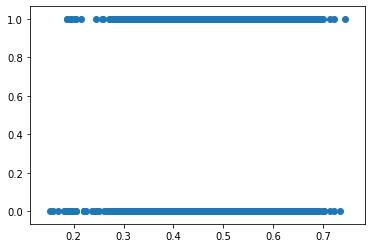

<IPython.core.display.Javascript object>

In [502]:
f, ax1 = plt.subplots()
ax1.scatter(df_eval_1M["predprob"], df_eval_1M["test"])

In [290]:
#def run_logreg_model_ub(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    log_reg = LogisticRegression()
    log_reg.fit(X_train_scale_set, y_train_set)

    y_pred = log_reg.predict(X_test_scale_set)
    y_predprob = log_reg.predict_proba(X_test_scale_set)[:, 1]
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred, "predprob": y_predprob})

    return log_reg, df_eval

<IPython.core.display.Javascript object>

In [291]:
# Run models
# log_reg_1M, df_eval_1M = run_logreg_model_ub(
#     X_train_scale_1M, y_train_1M, X_test_1M, y_test_1M
# )

<IPython.core.display.Javascript object>

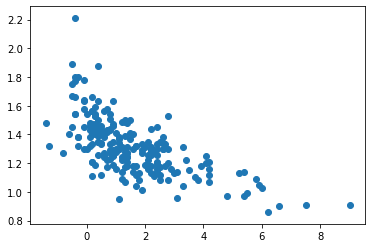

<IPython.core.display.Javascript object>

In [503]:
f, ax1 = plt.subplots()
ax1.scatter(df_pitching_stats_wpid_sp["WAR"], df_pitching_stats_wpid_sp["WHIP"])

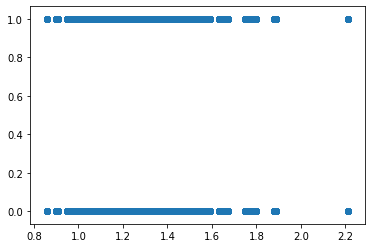

<IPython.core.display.Javascript object>

In [504]:
f, ax1 = plt.subplots()
ax1.scatter(df_sc_events4model_bp_ohe["WHIP"], df_sc_events4model_bp_ohe["event_code"])

### Logistic regression with L1 penalization

In [507]:
def run_logreg_model_L1(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    log_reg = LogisticRegression(
        class_weight="balanced", penalty="l1", solver="liblinear"
    )
    log_reg.fit(X_train_scale_set, y_train_set)

    y_pred = log_reg.predict(X_test_scale_set)
    y_predprob = log_reg.predict_proba(X_test_scale_set)[:, 1]
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred, "predprob": y_predprob})

    return log_reg, df_eval

<IPython.core.display.Javascript object>

In [508]:
# Run models
log_reg_1M_L1, df_eval_1M_L1 = run_logreg_model_L1(
    X_train_scale_1M, y_train_1M, X_test_scale_1M, y_test_1M
)

<IPython.core.display.Javascript object>

In [510]:
df_eval_1M_L1.head()

,test,pred,predprob
116951,1,1,0.512521
146125,1,1,0.504385
142042,0,1,0.537577
57356,0,1,0.563058
67644,0,1,0.596083


<IPython.core.display.Javascript object>

In [511]:
print(metrics.classification_report(df_eval_1M_L1["test"], df_eval_1M_L1["pred"]))

              precision    recall  f1-score   support

           0       0.70      0.52      0.60     62864
           1       0.35      0.53      0.42     30218

    accuracy                           0.52     93082
   macro avg       0.52      0.52      0.51     93082
weighted avg       0.58      0.52      0.54     93082



<IPython.core.display.Javascript object>

In [636]:
print("AUC: ", roc_auc_score(df_eval_1M_L1["test"], df_eval_1M_L1["pred"]))

AUC:  0.5238877570463994


<IPython.core.display.Javascript object>

### Random Forest

In [514]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier


<IPython.core.display.Javascript object>

In [517]:
def run_randomforest_v0(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators=1000, random_state=19)
    rf.fit(X_train_scale_set, y_train_set)

    y_pred = rf.predict(X_test_scale_set)
    y_predprob = rf.predict_proba(X_test_scale_set)[:, 1]
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred, "predprob": y_predprob})

    return rf, df_eval

<IPython.core.display.Javascript object>

### Testing with small test set



In [519]:
df_sc_events4model_bp_ohe.shape

(232703, 654)

<IPython.core.display.Javascript object>

In [553]:
df_sc_events4model_bp_ohe_small_test = df_sc_events4model_bp_ohe.iloc[0:100000, :]

<IPython.core.display.Javascript object>

In [554]:
df_sc_events4model_bp_ohe_small_test.shape

(100000, 654)

<IPython.core.display.Javascript object>

In [557]:
(
    X_train_scale_1M_small,
    X_test_scale_1M_small,
    y_train_1M_small,
    y_test_1M_small,
    scale_vals,
) = get_split_data(df_sc_events4model_bp_ohe_small_test[feature_col_w_target], 0.4)

<IPython.core.display.Javascript object>

In [558]:
# Run models
rand_for_1M_small_L1, df_eval_1M_small_L1 = run_randomforest_v0(
    X_train_scale_1M_small, y_train_1M_small, X_test_scale_1M_small, y_test_1M_small
)

<IPython.core.display.Javascript object>

In [559]:
df_eval_1M_small_L1.shape

(40000, 3)

<IPython.core.display.Javascript object>

In [637]:
print(
    metrics.classification_report(
        df_eval_1M_small_L1["test"], df_eval_1M_small_L1["pred"]
    )
)

              precision    recall  f1-score   support

           0       0.69      0.80      0.74     27401
           1       0.33      0.21      0.25     12599

    accuracy                           0.62     40000
   macro avg       0.51      0.51      0.50     40000
weighted avg       0.57      0.62      0.59     40000



<IPython.core.display.Javascript object>

In [638]:
print("AUC: ", roc_auc_score(df_eval_1M_small_L1["test"], df_eval_1M_small_L1["pred"]))

AUC:  0.5050818885906414


<IPython.core.display.Javascript object>

In [563]:
df_sc_events4model_bp_ohe_small_test["event_code"].value_counts()

0    68397
1    31603
Name: event_code, dtype: int64

<IPython.core.display.Javascript object>

In [ ]:
# decision tree, gradient boosting
# bagging


### GridSearch

- try different models


### PoissonRegression

In [ ]:
## Validation with historical data (already in split set)

In [ ]:
# Pick dates where a playerA-pitcher combination has shown up
# Input into the model - identify which is better

# Imagine that you wake up on August 1, 2019 and you didn't know who to pick.

# You had to choose between Santander and Leury Garcia (623993, 544725) 
# The starting pitcher Garcia is facing is...
# The starting pitcher Santander is facing is...

In [361]:
df_sc_events4model_bp.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,BB_perc,K_perc,key_mlbam_x,WAR_y,WHIP,ERA,BB/9,K/9,key_mlbam_y,event_code
0,2017-04-03,425783.0,446372.0,strikeout,L,R,Bot,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
1,2017-04-03,425783.0,446372.0,field_out,L,R,Bot,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
2,2017-04-03,425783.0,446372.0,field_out,L,R,Bot,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
3,2018-05-02,425783.0,446372.0,field_out,L,R,Top,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
4,2018-05-02,425783.0,446372.0,single,L,R,Top,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,1


<IPython.core.display.Javascript object>

In [358]:
df_sc_events4model_bp_ohe.head()

,game_date,events,WAR_x,OBP,SLG,OPS,BB_perc,K_perc,key_mlbam_x,WAR_y,...,b_660162.0,b_660271.0,b_660670.0,b_664023.0,b_664040.0,b_664056.0,b_664058.0,b_664068.0,b_665742.0,b_666971.0
0,2017-04-03,strikeout,2.3,0.377,0.434,0.81,0.138,0.235,425783,5.5,...,0,0,0,0,0,0,0,0,0,0
1,2017-04-03,field_out,2.3,0.377,0.434,0.81,0.138,0.235,425783,5.5,...,0,0,0,0,0,0,0,0,0,0
2,2017-04-03,field_out,2.3,0.377,0.434,0.81,0.138,0.235,425783,5.5,...,0,0,0,0,0,0,0,0,0,0
3,2018-05-02,field_out,2.3,0.377,0.434,0.81,0.138,0.235,425783,5.5,...,0,0,0,0,0,0,0,0,0,0
4,2018-05-02,single,2.3,0.377,0.434,0.81,0.138,0.235,425783,5.5,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [566]:
df_sc_events4model_bp_ohe["events"].value_counts()

field_out                       95188
strikeout                       48041
single                          34127
walk                            18469
double                          11051
home_run                         8189
grounded_into_double_play        4555
force_out                        4235
hit_by_pitch                     2243
field_error                      1868
sac_fly                          1390
triple                           1055
double_play                       549
sac_bunt                          370
fielders_choice_out               351
caught_stealing_2b                249
strikeout_double_play             247
fielders_choice                   207
pickoff_caught_stealing_2b         57
other_out                          56
pickoff_1b                         55
catcher_interf                     46
caught_stealing_3b                 23
pickoff_2b                         22
sac_fly_double_play                20
caught_stealing_home               15
triple_play 

<IPython.core.display.Javascript object>

In [387]:
# Return dates when both Santander and Sarcia played against a starting pitcher

pid1 = 623993
pid2 = 544725

date_list = [
    "'2019-08-02'",
    "'2019-08-03'",
    "'2019-08-04'",
    "'2019-08-05'",
    "'2019-08-06'",
    "'2019-08-07'",
    "'2019-08-09'",
    "'2019-08-10'",
    "'2019-08-16'",
    "'2019-08-17'",
    "'2019-08-18'",
    "'2019-08-19'",
    "'2019-08-20'",
    "'2019-08-21'",
    "'2019-08-22'",
    "'2019-08-23'",
    "'2019-08-24'",
    "'2019-08-25'",
    "'2019-08-27'",
    "'2019-08-28'",
    "'2019-08-30'",
    "'2019-08-31'",
    "'2019-09-01'",
    "'2019-09-02'",
    "'2019-09-03'",
    "'2019-09-10'",
    "'2019-09-11'",
    "'2019-09-12'",
    "'2019-09-16'",
    "'2019-09-18'",
    "'2019-09-21'",
]

for date in date_list:
    playerA_ab = (
        (df_sc_events4model_bp["batter"] == pid1)
        & (df_sc_events4model_bp["game_date"] == date)
    ).sum()

    playerB_ab = (
        (df_sc_events4model_bp["batter"] == pid2)
        & (df_sc_events4model_bp["game_date"] == date)
    ).sum()

    if (playerA_ab > 1) & (playerB_ab > 1):
        print(date)

    if date is "2019-09-18":
        break

'2019-08-02'
'2019-08-03'
'2019-08-09'
'2019-08-10'
'2019-08-19'
'2019-08-21'
'2019-08-22'
'2019-08-23'
'2019-08-28'
'2019-08-31'
'2019-09-01'
'2019-09-03'
'2019-09-10'
'2019-09-18'


<IPython.core.display.Javascript object>

In [389]:
date = "2019-09-18"

<IPython.core.display.Javascript object>

In [394]:
playerA_ab = (
    (df_sc_events4model_bp["batter"] == pid1)
    & (df_sc_events4model_bp["game_date"] == date)
).sum()

<IPython.core.display.Javascript object>

In [395]:
playerA_ab

3

<IPython.core.display.Javascript object>

In [376]:
df_sc_events4model_bp.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,BB_perc,K_perc,key_mlbam_x,WAR_y,WHIP,ERA,BB/9,K/9,key_mlbam_y,event_code
0,2017-04-03,425783.0,446372.0,strikeout,L,R,Bot,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
1,2017-04-03,425783.0,446372.0,field_out,L,R,Bot,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
2,2017-04-03,425783.0,446372.0,field_out,L,R,Bot,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
3,2018-05-02,425783.0,446372.0,field_out,L,R,Top,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
4,2018-05-02,425783.0,446372.0,single,L,R,Top,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,1


<IPython.core.display.Javascript object>

In [405]:
date_to_pick = "2019-08-02"

<IPython.core.display.Javascript object>

In [406]:
df_sc_events4model_bp_p1_dayof = df_sc_events4model_bp.loc[
    (
        (df_sc_events4model_bp["batter"] == pid1)
        & (df_sc_events4model_bp["game_date"] == date_to_pick)
    ),
    :,
]

<IPython.core.display.Javascript object>

In [407]:
df_sc_events4model_bp_p2_dayof = df_sc_events4model_bp.loc[
    (
        (df_sc_events4model_bp["batter"] == pid2)
        & (df_sc_events4model_bp["game_date"] == date_to_pick)
    ),
    :,
]

<IPython.core.display.Javascript object>

In [408]:
df_sc_events4model_bp_p1_dayof

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,BB_perc,K_perc,key_mlbam_x,WAR_y,WHIP,ERA,BB/9,K/9,key_mlbam_y,event_code
130524,2019-08-02,623993.0,592468.0,field_out,L,R,Bot,-0.4,0.25,0.297,...,0.056,0.194,623993,-0.3,1.38,5.21,3.08,8.17,592468.0,0
132126,2019-08-02,623993.0,543208.0,single,L,R,Bot,-0.4,0.25,0.297,...,0.056,0.194,623993,0.8,1.44,5.31,2.77,7.64,543208.0,1


<IPython.core.display.Javascript object>

In [409]:
df_sc_events4model_bp_p2_dayof

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,BB_perc,K_perc,key_mlbam_x,WAR_y,WHIP,ERA,BB/9,K/9,key_mlbam_y,event_code
162833,2019-08-02,544725.0,601713.0,strikeout,L,R,Top,0.1,0.303,0.376,...,0.033,0.251,544725,2.8,1.30,4.77,2.80,10.32,601713.0,0
164140,2019-08-02,544725.0,621107.0,field_out,L,R,Top,0.1,0.303,0.376,...,0.033,0.251,544725,2.2,1.30,4.36,2.60,8.65,621107.0,0
197404,2019-08-02,544725.0,450306.0,strikeout,R,L,Top,0.1,0.303,0.376,...,0.033,0.251,544725,0.2,1.41,5.77,2.93,8.22,450306.0,0
197405,2019-08-02,544725.0,450306.0,field_out,R,L,Top,0.1,0.303,0.376,...,0.033,0.251,544725,0.2,1.41,5.77,2.93,8.22,450306.0,0
197406,2019-08-02,544725.0,450306.0,single,R,L,Top,0.1,0.303,0.376,...,0.033,0.251,544725,0.2,1.41,5.77,2.93,8.22,450306.0,1


<IPython.core.display.Javascript object>

In [411]:
p1_index4model = df_sc_events4model_bp_p1_dayof.index

<IPython.core.display.Javascript object>

In [412]:
p2_index4model = df_sc_events4model_bp_p2_dayof.index

<IPython.core.display.Javascript object>

In [453]:
def run_logreg_model_new_data(df4model, index_new_set, scaler, log_model):

    full_list = df4model.columns.tolist()
    full_list.remove("event_code")
    X_new_set = df4model.loc[index_new_set, full_list]
    X_new_set = np.array(X_new_set)

    y_test_set = df4model.loc[index_new_set, "event_code"]

    from sklearn import preprocessing

    # Apply transformation to test data
    X_new_set_scale = scaler.transform(X_new_set)

    y_pred = log_model.predict(X_new_set_scale)
    y_predprob = log_model.predict_proba(X_new_set_scale)[:, 1]
    df_pred_actual = pd.DataFrame(
        {"results": y_test_set, "pred": y_pred, "predprob": y_predprob}
    )

    return df_pred_actual

<IPython.core.display.Javascript object>

In [456]:
df_pa_b1 = run_logreg_model_new_data(
    df_sc_events4model_bp_ohe[feature_col_w_target],
    p1_index4model,
    scale_vals,
    log_reg_1M,
)

<IPython.core.display.Javascript object>

In [457]:
df_pa_b1.head()

,results,pred,predprob
130524,0,0,0.493440
132126,1,1,0.502157


<IPython.core.display.Javascript object>

In [463]:
df_pa_b1["predprob"].mean()

0.4977984262309553

<IPython.core.display.Javascript object>

In [459]:
df_pa_b2 = run_logreg_model_new_data(
    df_sc_events4model_bp_ohe[feature_col_w_target],
    p2_index4model,
    scale_vals,
    log_reg_1M,
)

<IPython.core.display.Javascript object>

# Predicting strikeouts

## New copy of events dataframe

In [578]:
df_sc_events4model_bp_k = df_sc_events4model_bp.copy()

<IPython.core.display.Javascript object>

In [579]:
df_sc_events4model_bp_k.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,BB_perc,K_perc,key_mlbam_x,WAR_y,WHIP,ERA,BB/9,K/9,key_mlbam_y,event_code
0,2017-04-03,425783.0,446372.0,strikeout,L,R,Bot,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
1,2017-04-03,425783.0,446372.0,field_out,L,R,Bot,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
2,2017-04-03,425783.0,446372.0,field_out,L,R,Bot,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
3,2018-05-02,425783.0,446372.0,field_out,L,R,Top,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
4,2018-05-02,425783.0,446372.0,single,L,R,Top,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,1


<IPython.core.display.Javascript object>

In [580]:
df_sc_events4model_bp_k["events"].value_counts()

field_out                       95188
strikeout                       48041
single                          34127
walk                            18469
double                          11051
home_run                         8189
grounded_into_double_play        4555
force_out                        4235
hit_by_pitch                     2243
field_error                      1868
sac_fly                          1390
triple                           1055
double_play                       549
sac_bunt                          370
fielders_choice_out               351
caught_stealing_2b                249
strikeout_double_play             247
fielders_choice                   207
pickoff_caught_stealing_2b         57
other_out                          56
pickoff_1b                         55
catcher_interf                     46
caught_stealing_3b                 23
pickoff_2b                         22
sac_fly_double_play                20
caught_stealing_home               15
triple_play 

<IPython.core.display.Javascript object>

In [581]:
# Encode events
event_list = ["strikeout"]
df_sc_events4model_bp_k["event_code"] = 0
df_sc_events4model_bp_k.loc[
    df_sc_events4model_bp_k["events"].isin(event_list), "event_code"
] = 1

<IPython.core.display.Javascript object>

In [591]:
# OHE batter, pitcher handedness
# OHE top/away, home/bottom
df_sc_events4model_bp_k['stand'].replace({'L':0, 'R':1}, inplace=True)

df_sc_events4model_bp_k['p_throws'].replace({'L':0, 'R':1}, inplace=True)

df_sc_events4model_bp_k['inning_topbot'].replace({'Top':0, 'Bot':1}, inplace=True)


<IPython.core.display.Javascript object>

In [592]:
df_sc_events4model_bp_k.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,BB_perc,K_perc,key_mlbam_x,WAR_y,WHIP,ERA,BB/9,K/9,key_mlbam_y,event_code
0,2017-04-03,425783.0,446372.0,strikeout,0,1,1,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,1
1,2017-04-03,425783.0,446372.0,field_out,0,1,1,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
2,2017-04-03,425783.0,446372.0,field_out,0,1,1,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
3,2018-05-02,425783.0,446372.0,field_out,0,1,0,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0
4,2018-05-02,425783.0,446372.0,single,0,1,0,2.3,0.377,0.434,...,0.138,0.235,425783,5.5,0.99,2.89,1.42,9.29,446372.0,0


<IPython.core.display.Javascript object>

In [593]:
# OHE pitcher
df_sc_events4model_bp_k_ohe = pd.get_dummies(
    df_sc_events4model_bp_k, prefix=["p"], columns=["pitcher"]
)

# OHE batter
df_sc_events4model_bp_k_ohe = pd.get_dummies(
    df_sc_events4model_bp_k_ohe, prefix=["b"], columns=["batter"]
)

<IPython.core.display.Javascript object>

In [594]:
df_sc_events4model_bp_k_ohe.head()

,game_date,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,OPS,BB_perc,...,b_660162.0,b_660271.0,b_660670.0,b_664023.0,b_664040.0,b_664056.0,b_664058.0,b_664068.0,b_665742.0,b_666971.0
0,2017-04-03,strikeout,0,1,1,2.3,0.377,0.434,0.81,0.138,...,0,0,0,0,0,0,0,0,0,0
1,2017-04-03,field_out,0,1,1,2.3,0.377,0.434,0.81,0.138,...,0,0,0,0,0,0,0,0,0,0
2,2017-04-03,field_out,0,1,1,2.3,0.377,0.434,0.81,0.138,...,0,0,0,0,0,0,0,0,0,0
3,2018-05-02,field_out,0,1,0,2.3,0.377,0.434,0.81,0.138,...,0,0,0,0,0,0,0,0,0,0
4,2018-05-02,single,0,1,0,2.3,0.377,0.434,0.81,0.138,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [595]:
col2remove = ["game_date", "events", "key_mlbam_x", "key_mlbam_y"]
all_col = df_sc_events4model_bp_k_ohe.columns.tolist()

<IPython.core.display.Javascript object>

In [596]:
feature_col_w_target = sorted(list(set(all_col) - set(col2remove)))

<IPython.core.display.Javascript object>

In [597]:
feature_col_w_target

['BB/9',
 'BB_perc',
 'ERA',
 'K/9',
 'K_perc',
 'OBP',
 'OPS',
 'SLG',
 'WAR_x',
 'WAR_y',
 'WHIP',
 'b_134181.0',
 'b_400121.0',
 'b_400284.0',
 'b_405395.0',
 'b_408045.0',
 'b_408234.0',
 'b_408236.0',
 'b_408314.0',
 'b_425772.0',
 'b_425783.0',
 'b_425877.0',
 'b_429664.0',
 'b_429665.0',
 'b_430832.0',
 'b_430945.0',
 'b_431145.0',
 'b_434158.0',
 'b_434658.0',
 'b_434670.0',
 'b_434778.0',
 'b_435062.0',
 'b_435064.0',
 'b_435079.0',
 'b_435263.0',
 'b_435522.0',
 'b_435559.0',
 'b_435622.0',
 'b_443558.0',
 'b_444432.0',
 'b_444482.0',
 'b_444489.0',
 'b_444876.0',
 'b_445055.0',
 'b_445988.0',
 'b_446263.0',
 'b_446308.0',
 'b_446334.0',
 'b_446359.0',
 'b_446386.0',
 'b_446481.0',
 'b_448602.0',
 'b_448801.0',
 'b_450314.0',
 'b_451192.0',
 'b_451594.0',
 'b_452095.0',
 'b_452254.0',
 'b_452655.0',
 'b_452678.0',
 'b_453568.0',
 'b_453923.0',
 'b_453943.0',
 'b_455104.0',
 'b_455117.0',
 'b_455139.0',
 'b_455759.0',
 'b_455976.0',
 'b_456078.0',
 'b_456124.0',
 'b_456488.0',

<IPython.core.display.Javascript object>

In [598]:
X_train_scale_1M, X_test_scale_1M, y_train_1M, y_test_1M, scale_vals = get_split_data(
    df_sc_events4model_bp_k_ohe[feature_col_w_target], 0.4
)

<IPython.core.display.Javascript object>

In [599]:
# Run models
log_reg_1M, df_eval_1M = run_logreg_model(
    X_train_scale_1M, y_train_1M, X_test_scale_1M, y_test_1M
)

<IPython.core.display.Javascript object>

In [605]:
df_eval_1M.head()

,test,pred,predprob
116951,0,1,0.504093
146125,0,0,0.412483
142042,1,0,0.466282
57356,0,1,0.630782
67644,1,0,0.498161


<IPython.core.display.Javascript object>

In [602]:
print(metrics.classification_report(df_eval_1M["test"], df_eval_1M["pred"]))

              precision    recall  f1-score   support

           0       0.84      0.58      0.69     73947
           1       0.26      0.57      0.36     19135

    accuracy                           0.58     93082
   macro avg       0.55      0.58      0.52     93082
weighted avg       0.72      0.58      0.62     93082



<IPython.core.display.Javascript object>

## Plot ROC curve

In [604]:
from sklearn import metrics

<IPython.core.display.Javascript object>

In [629]:
fpr, tpr, thresholds = metrics.roc_curve(df_eval_1M["test"], df_eval_1M["pred"])

<IPython.core.display.Javascript object>

In [630]:
fpr

array([0.        , 0.41907042, 1.        ])

<IPython.core.display.Javascript object>

In [631]:
tpr

array([0.        , 0.57496734, 1.        ])

<IPython.core.display.Javascript object>

In [610]:
thresholds

array([2, 1, 0])

<IPython.core.display.Javascript object>

In [632]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

<IPython.core.display.Javascript object>

In [ ]:
roc_auc_score

In [635]:
# from sklearn.metrics import rocaucscore

# predictions = model.predict(vect.transform(Xtest))
# print('AUC: ', rocaucscore(ytest, predictions))

print("AUC: ", roc_auc_score(df_eval_1M["test"], df_eval_1M["pred"]))

AUC:  0.5779484610212551


<IPython.core.display.Javascript object>

In [633]:
# Compute ROC curve and ROC area for each class
fpr_d = dict()
tpr_d = dict()
roc_auc = dict()
for i in range(2):
    #     fpr[i], tpr[i], _ = roc_curve(
    #         df_eval_1M["test"].iloc[i], df_eval_1M["pred"].iloc[i]
    #     )
    fpr_d[i], tpr_d[i] = fpr[i], tpr[i]

    roc_auc[i] = auc(fpr_d[i], tpr_d[i])

# Compute micro-average ROC curve and ROC area
fpr_d["micro"], tpr_d["micro"], _ = roc_curve(
    df_eval_1M["test"].ravel(), df_eval_1M["pred"].ravel()
)
roc_auc["micro"] = auc(fpr_d["micro"], tpr_d["micro"])

TypeError: Singleton array 0.0 cannot be considered a valid collection.

<IPython.core.display.Javascript object>